### Hipótese
ZCTAs com maior renda tendem a gerar maior receita.

---

In [34]:
# Importando bibliotecas
import warnings
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [35]:
# Carregando os data sets relacionados
transactional_data = pd.read_csv('../../../data/processed/transactional_data_clean.csv')
economic_data = pd.read_csv('../../../data/processed/economic_data_clean.csv')
geocode_data = pd.read_csv('../../../data/processed/geocode_data_clean.csv')

In [36]:
# 1. Aproximação de renda média ponderada por ZCTA

# Mapeando faixas de renda para valores numéricos
income_mapping = {
    '< $10.000': 5000,
    '$10.000 - $14.999': 12500,
    '$15.000 - $24.999': 20000,
    '$25.000 - $34.999': 30000,
    '$35.000 - $49.999': 42500,
    '$50.000 - $74.999': 62500,
    '$75.000 - $99.999': 87500,
    '$100.000 - $149.999': 125000,
    '$150.000 - $199.999': 175000,
    '$200.000 >=': 250000 
}

# Adicionando coluna com valor numérico aproximado para cada faixa de renda
economic_data['income_value'] = economic_data['household_range'].map(income_mapping)

In [37]:
# Calculando a renda média ponderada por ZCTA
weighted_income = economic_data.groupby('zipcode').apply(
    lambda x: sum(x['income_value'] * x['total_households']) / x['total_households'].sum(), include_groups=False
)

# Transformando em um dataframe
weighted_income_df = weighted_income.reset_index()
weighted_income_df.columns = ['zipcode', 'weighted_avg_income']

# Formatando a coluna 'zipcode' como str
weighted_income_df['zipcode'] = weighted_income_df['zipcode'].astype(float)

weighted_income_df.head()

,zipcode,weighted_avg_income
0,601.0,21281.993102
1,602.0,26385.792779
2,603.0,27007.879135
3,606.0,17896.968140
4,610.0,28714.042069


In [38]:
# 2. Relacionando a renda média calculada com os zipcode dos laboratórios

transactional_data['lab_id'] = transactional_data['lab_id'].astype(str)
geocode_data['lab_id'] = geocode_data['lab_id'].astype(str)

# Unindo os dados transacionais com os dados de geocodificação
trans_geo = transactional_data.merge(geocode_data, on='lab_id', how='left')

In [39]:
# Calculando receita total por ZCTA
revenue_by_zcta = trans_geo.groupby('zipcode')['testing_cost'].sum().reset_index()
revenue_by_zcta.columns = ['zipcode', 'total_revenue']

# Calculando o valor médio dos exames por ZCTA
avg_exam_value_by_zcta = trans_geo.groupby('zipcode')['testing_cost'].mean().reset_index()
avg_exam_value_by_zcta.columns = ['zipcode', 'avg_exam_value']

avg_exam_value_by_zcta.head()

,zipcode,avg_exam_value
0,1605.0,22.740764
1,1606.0,27.376688
2,1701.0,28.702070
3,1702.0,22.583950
4,1840.0,27.887538


In [40]:
# Mesclando receita e renda por ZCTA
income_revenue = weighted_income_df.merge(revenue_by_zcta, on='zipcode', how='inner')
income_revenue = income_revenue.merge(avg_exam_value_by_zcta, on='zipcode', how='inner')

# Verificando os dados após a mesclagem
income_revenue.head()

,zipcode,weighted_avg_income,total_revenue,avg_exam_value
0,1605.0,56764.264968,282872.36,22.740764
1,1606.0,81658.904277,216221.08,27.376688
2,1701.0,122032.710280,459807.16,28.702070
3,1702.0,82796.640810,447726.80,22.583950
4,1840.0,43300.220751,879405.62,27.887538


In [41]:
# 3. Cálculo da Correlação de Pearson

# Calculando correlação entre renda média e receita total
corr_income_revenue, p_value_revenue = stats.pearsonr(income_revenue['weighted_avg_income'], income_revenue['total_revenue'])

# Calculando correlação entre renda média e valor médio dos exames
corr_income_exam_value, p_value_exam = stats.pearsonr(income_revenue['weighted_avg_income'], income_revenue['avg_exam_value'])

print(f"Correlação entre renda média e receita total: {corr_income_revenue:.4f} (p-value: {p_value_revenue:.4f})")
print(f"Correlação entre renda média e valor médio dos exames: {corr_income_exam_value:.4f} (p-value: {p_value_exam:.4f})")

Correlação entre renda média e receita total: -0.0303 (p-value: 0.7624)
Correlação entre renda média e valor médio dos exames: -0.0490 (p-value: 0.6251)


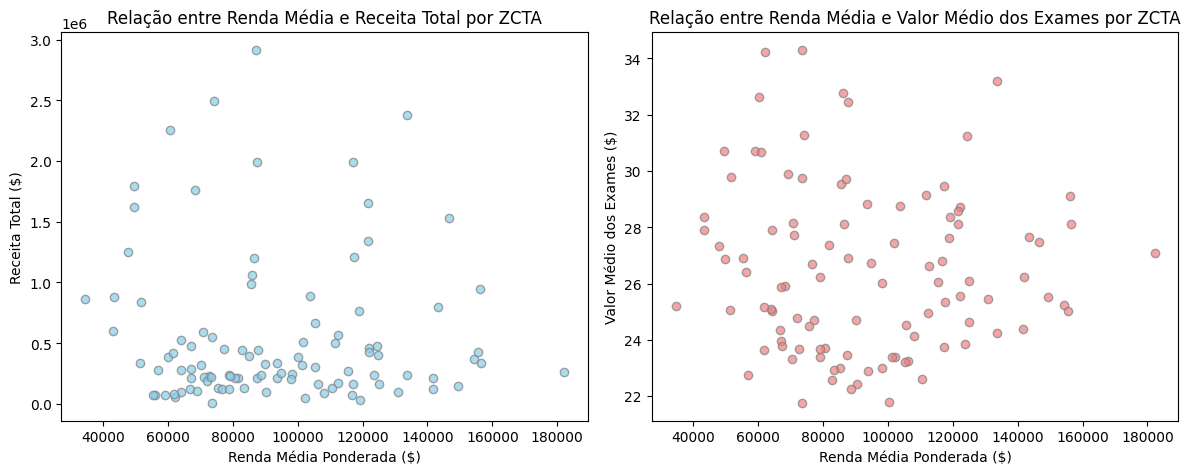

In [42]:
# 5. Visualização dos Resultados de correlação

plt.figure(figsize=(12, 5))

# Gráfico de dispersão: Renda Média vs Receita Total
plt.subplot(1, 2, 1)
plt.scatter(income_revenue['weighted_avg_income'], income_revenue['total_revenue'], 
            alpha=0.7, edgecolor='gray', color='skyblue')
plt.title('Relação entre Renda Média e Receita Total por ZCTA')
plt.xlabel('Renda Média Ponderada ($)')
plt.ylabel('Receita Total ($)')

# Gráfico de dispersão: Renda Média vs Valor Médio dos Exames
plt.subplot(1, 2, 2)
plt.scatter(income_revenue['weighted_avg_income'], income_revenue['avg_exam_value'], 
            alpha=0.7, edgecolor='gray', color='lightcoral')
plt.title('Relação entre Renda Média e Valor Médio dos Exames por ZCTA')
plt.xlabel('Renda Média Ponderada ($)')
plt.ylabel('Valor Médio dos Exames ($)')

plt.tight_layout()


In [43]:
# 6. Segregação por quartis de renda

# Criando quartis de renda
income_revenue['income_quartile'] = pd.qcut(income_revenue['weighted_avg_income'], 4, labels=['Q1 (Baixa)', 'Q2 (Média-Baixa)', 'Q3 (Média-Alta)', 'Q4 (Alta)'])

# Análise por quartil
quartile_analysis = income_revenue.groupby('income_quartile').agg({
    'weighted_avg_income': 'mean',
    'total_revenue': 'mean',
    'avg_exam_value': 'mean',
}).reset_index()

Text(0, 0.5, 'Receita Média ($)')

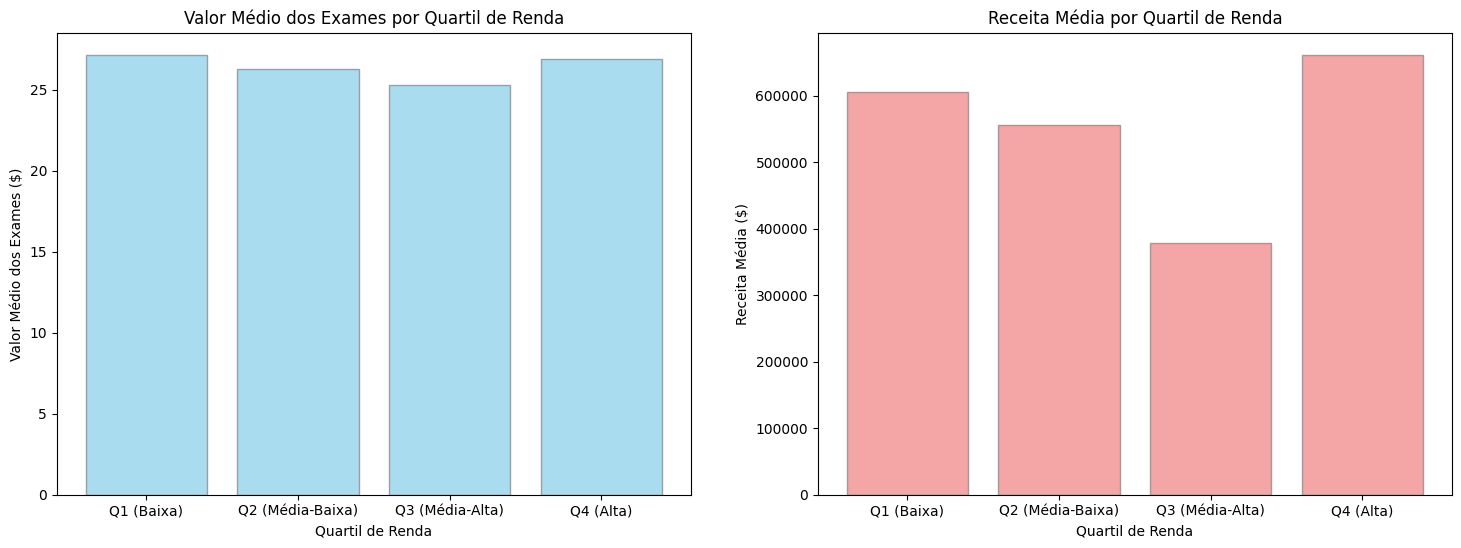

In [44]:
# 7. Visualização dos resultados de segragação por quartis

plt.figure(figsize=(18, 6))

# Valor Médio dos Exames por Quartil de Renda
plt.subplot(1, 2, 1)
plt.bar(quartile_analysis['income_quartile'], quartile_analysis['avg_exam_value'], 
        color='skyblue', edgecolor='gray', alpha=0.7)
plt.title('Valor Médio dos Exames por Quartil de Renda')
plt.xlabel('Quartil de Renda')
plt.ylabel('Valor Médio dos Exames ($)')

# Receita Média por Quartil de Renda
plt.subplot(1, 2, 2)
plt.bar(quartile_analysis['income_quartile'], quartile_analysis['total_revenue'], 
        color='lightcoral', edgecolor='gray', alpha=0.7)
plt.title('Receita Média por Quartil de Renda')
plt.xlabel('Quartil de Renda')
plt.ylabel('Receita Média ($)')


---

### Conclusão

A hipótese inicial proposta foi rejeitada pela análise estatística de correlação linear. Os resultados mostram correlações praticamente nulas:

1. Correlação entre renda média e receita total: -0.0303 (p-value: 0.7624)
2. Correlação entre renda média e valor médio dos exames: -0.0490 (p-value: 0.6251)

Os p-values elevados (>0.05) indicam que estas correlações não são estatisticamente significativas, o que sugere que não existe uma relação linear direta entre o nível de renda de uma região e o desempenho financeiro dos laboratórios nela localizados, como ilustrado no gráfico de renda média por receita e por valor do exame.

No entanto, a análise por quartis de renda revela que ZCTAs com renda média-alta (Q3) apresentam a menor receita média entre todos os grupos, conforme demonstrado no gráfico "Receita Média por Quartil de Renda".

Portanto, embora a hipótese inicial tenha sido rejeitada, os resultados fornecem uma orientação estratégica relevante para o plano de expansão: áreas com renda média-alta (Q3) devem ser consideradas de menor prioridade, pois demonstram menor potencial de geração de receita para a rede de laboratórios.